# Global Utility Functions
**Description**

This notebook contains shared functions used in other notebook. 

- *Plotting* and *Reporting/printing* related functions are mostly cosmetical to generate nice plots for the thesis and provide easy readable output.
- The function that are *Scoring* related are important, as they are used to calculate the evaluation metrics. 
- The *Data Preparation* related functions are also very important, as they include the sliding window logic, and the (quite complex) normalization & cv scenario creation logic.

The functions are followed by a *Check function* cell, which is used to demonstrated the different functions for transparency and sanity check their logic. This transparency, by demonstrating the results right next to the code is also the reason, why I implemented these functions as a Jupyter Notebook instead as a Python Module (where it would be better placed for more productive scenarios)

**Usage**

1. To make the functions in this notebook available in another notebook, run the following line in the consuming notebook:
```
%run utils.ipynb
```


2. To investigate the functions inside this notebook, enable the testing output by setting in the configuration section ([1. Preparations](#1)):
```
TEST_MODE = True
```

**Table of Contents**

**1 - [Preparations](#1)**  
**2 - [Plotting related](#2)**  
**3 - [Reporting/printing related](#3)**  
**4 - [Scoring related](#4)**  
**5 - [Data Preparation related](#5)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### Imports

In [18]:
# Standard
import warnings
import random
from pathlib import Path

# Extra
import pandas as pd
import numpy as np
from dataclasses import asdict
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, make_scorer, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils import resample as sk_resample
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import animation, rc
from tqdm.auto import tqdm
from IPython.display import HTML

### Configuration
Only relevant for sanity checking function in this notebook.

In [2]:
TEST_MODE = False  # Set to "True" to perform sanity checks, set to "False" before importing this notebook into others
MAGENTA = (202/255, 18/255, 125/255)

## 2. Plotting related <a id='2'>&nbsp;</a> 

### utils_save_plot()

In [3]:
def utils_save_plot(fig, filepath):
    """Save plot to file using certain layout and dpi."""
    fig.savefig(filepath, bbox_inches="tight", pad_inches=0.01, dpi=600)

**Check Function:**

In [4]:
if TEST_MODE:
    plt.plot([1, 3, 2, 4])
    
    TEST_OUTPUT_PATH = Path.cwd() / "output" / "utils"
    TEST_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
    
    utils_save_plot(plt, TEST_OUTPUT_PATH / "utils_save_plot.png")

### utils_set_output_style()

In [5]:
def utils_set_output_style():
    """Set styles for matplotlib charts and pandas tables."""

    # Charts
    # for seaborn:
    sns.set_style("darkgrid")
    sns.set_context("paper")
    sns.set(font="sans")
    sns.set_palette("tab10")
    # for plain matplotlib:
    plt.style.use(["seaborn-darkgrid", "seaborn-paper"])
    plt.rc("font", family="sans", size=8)
    plt.rc("axes", titlesize=6)
    plt.rc("axes", labelsize=6)
    plt.rc("xtick", labelsize=6)
    plt.rc("ytick", labelsize=6)
    plt.rc("xtick.major", pad=1)
    plt.rc("ytick.major", pad=3)
    plt.rc("legend", fontsize=6)
    plt.rc("figure", titlesize=6)

    # Tables
    pd.set_option("display.max_rows", 500)
    pd.set_option("display.max_columns", 500)
    pd.set_option("display.width", 1000)
    pd.plotting.register_matplotlib_converters()

**Check Function:**

In [6]:
if TEST_MODE:
    utils_set_output_style()
    plt.plot([1, 3, 2, 4])

### utils_boxplot_style &lt;dict&gt;, utils_lineplot_style &lt;dict&gt;

In [7]:
# Define a style I use a lot for boxplots:
utils_boxplot_style = dict(
    color="tab:blue",
    linewidth=0.5,
    saturation=1,
    width=0.7,
    flierprops=dict(
        marker="o", markersize=2, markerfacecolor="none", markeredgewidth=0.5
    ),
)

# Define a style I use a lot for lineplots:
utils_lineplot_style = dict(
    color="tab:blue", linewidth=0.5, marker="o", markersize=3, markeredgewidth=0.5
)

**Check Function:**

In [8]:
if TEST_MODE:
    utils_set_output_style()
    fig = plt.figure(dpi=180, figsize=(5.473, 2))
    sns.boxplot(
        x=["Dist 1", "Dist 2"],
        y=[[2, 4, 3, 4, 15, 8, 3, 0, 2, 21], [12, 14, 13, 17, 15, 8, 11, 0, 2, 21]],
        **utils_boxplot_style
    )

### utils_plot_randomsearch_results()

In [9]:
def utils_plot_randomsearch_results(df_results, n_top=1):
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
            "param_nu": r"$\nu$",
            "param_gamma": r"$\gamma$",
            "mean_test_accuracy": "Mean Test Acc.",
            "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    median_nu = df_plot[r"$\nu$"].median()
    median_gamma = df_plot[r"$\gamma$"].median()

    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=180)
    g = sns.scatterplot(
        x=r"$\nu$",
        y=r"$\gamma$",
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in enumerate(leg.legendHandles):
        label = handle.get_label()
        try:
            new_labels.append(f"{abs(float(label)):.3f}")
        except ValueError:
            new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [median_gamma, median_gamma],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        median_gamma * 1.7 ** 2,
        r"median($\gamma$)",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        median_gamma * 1.2 ** 2,
        f"{median_gamma:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [median_nu, median_nu],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        median_nu + 0.005, 400, r"median($\nu$)", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        median_nu + 0.005, 200, f"{median_nu:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    return fig

### utils_plot_session_probability()

In [12]:
def utils_plot_session_probability(y_impostor, subject, session):
    """Plot the owner probability for every sample of session."""
    df_y = pd.DataFrame(y_impostor).transpose()
    import matplotlib.ticker as ticker

    # Plot heatmap
    fig = plt.figure(figsize=(5.473, 0.6), dpi=180)
    heatmap = sns.heatmap(
        df_y,
        cmap="RdYlGn_r",
        annot=False,
        vmin=0,
        vmax=1,
        cbar_kws={"aspect": 10, "pad": 0.01, "shrink": 1},
        yticklabels=0,
    )
    start, end = heatmap.get_xlim()
    stepsize = 50
    heatmap.xaxis.set_ticks(np.arange(start, end, stepsize))
    heatmap.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.f"))

    # Adjust labels
    heatmap.set_ylabel(
        f'Impostor Propability\n(Owner "{subject}")',
        labelpad=5,
        rotation=0,
        ha="right",
        va="center",
    )
    heatmap.set_xlabel(f'Samples of Session "{session}"', labelpad=3)

    return plt

**Check Function:**

In [13]:
if TEST_MODE:
    y_impostor = [0.2, 0.3, 0.15, 0.4, 0.7, 0.65, 0.1, 0.3, 0.9, 0.01, 0.87, 0.79, 0.93, 0.98]
    utils_plot_session_probability(y_impostor, "123456", "7890")

### utils_plot_training_loss()

In [19]:
def utils_plot_training_loss(history):
    """Plot Train/Valid Loss during Epochs."""
    fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
    plt.plot(history.history["loss"], label="train", color="tab:blue")
    plt.plot(history.history["val_loss"], label="valid", color=MAGENTA)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="upper right")
    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.tight_layout()
    return plt

**Check Function:**

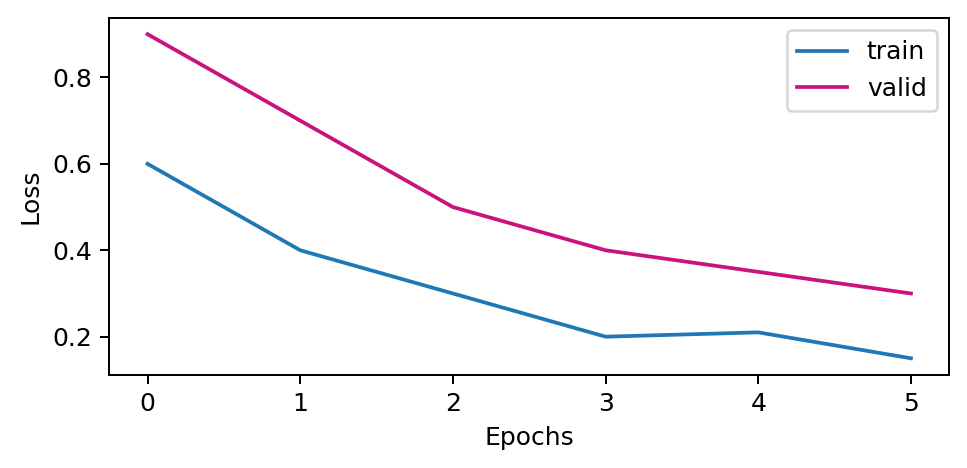

In [20]:
if TEST_MODE:
    HistoryDummy = type("History", (object,), {})
    history = HistoryDummy()
    history.history = {}
    history.history["loss"] = [0.6, 0.4, 0.3, 0.2, 0.21, 0.15]
    history.history["val_loss"] = [0.9, 0.7, 0.5, 0.4, 0.35, 0.3]
    utils_plot_training_loss(history)

### plot_acc_eer_dist()

In [74]:
def utils_plot_acc_eer_dist(df_plot, y_col):
    n_subject = len(df_plot["Owner"].unique()) - 1
    mean_col = df_plot[y_col].mean()

    fig = plt.figure(figsize=(5.473, 2), dpi=180)
    ax = sns.boxplot(x="Owner", y=y_col, data=df_plot, **utils_boxplot_style)
    ax.set_ylim((0, 1))

    plt.plot(
        [-0.6, n_subject + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=6, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=4.5, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    
    print(f"Overall mean: {mean_col:.4f}")
    return fig

### utils_plot_training_delay()

In [75]:
def utils_plot_training_delay(df_plot):
    fig = plt.figure(figsize=(5.473/2.05, 1.7), dpi=180)
    ax = sns.lineplot(x="Training Data in Seconds", y="Test EER", data=df_plot, **utils_lineplot_style)
    ax.set_ylim((0, 0.6))
    ax.get_children()[1].set_marker("o")
    fig.tight_layout()
    return fig

### utils_plot_distance_hist()

In [76]:
def utils_plot_distance_hist(dist_positive, dist_negative, thres, desc, margin=None):
    """Plot histogramm of Euclidean Distances for Positive & Negative Pairs."""

    warnings.filterwarnings("ignore")

    # Plot Distributions
    plt.figure(figsize=(5.473, 0.6), dpi=180)
    bins = np.linspace(
        min(dist_positive.min(), dist_negative.min()),
        max(dist_positive.max(), dist_negative.max()),
        num=21,
    )
    g1 = sns.distplot(
        dist_positive,
        label="positive pairs",
        bins=bins,
        axlabel=False,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:blue",
    )
    g2 = sns.distplot(
        dist_negative,
        label="negative pairs",
        bins=bins,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:gray",
    )

    # Plot vertical lines
    if thres > 0:
        max_y = max(g1.get_ylim()[1], g2.get_ylim()[1])
        plt.axvline(x=thres, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
        plt.text(
            x=thres + 0.001,
            y=max_y * 0.65,
            s=f"EER Threshold\n({thres:.2f})",
            color=MAGENTA,
            weight="bold",
            fontsize=5,
            alpha=1
        )
        if margin:
            plt.axvline(x=margin, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
            plt.text(
                x=margin + 0.001,
                y=max_y * 0.15,
                s=f"Margin\n({margin})",
                color=MAGENTA,
                weight="bold",
                fontsize=5,
                alpha=1
            )

    # Legend
    plt.legend(
        loc="upper right",
        title=f"{desc} Distances",
        title_fontsize=5,
        fontsize=6,
    )

    warnings.filterwarnings("default")
    return plt

**Check Function:**

In [77]:
if TEST_MODE:
    dist_pos = np.array([0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.5, 0.8])
    dist_neg = np.array([0.4, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 1, 1])
    utils_plot_distance_hist(
        dist_pos, dist_neg, thres=0.4, desc="Pair", fig_size=(12, 4), margin=0.8
    )

### utils_plot_detect_delay():

In [78]:
def utils_plot_detect_delay(df_plot, factor, xlim):
    # Desired Error Margin
    THRES_ERROR_MARGIN = 0.025  # +-

    # Start Plotting
    fig, axes = plt.subplots(
        ncols=5, nrows=2, sharex=True, sharey=True, figsize=(5.473, 3), dpi=180
    )
    plt.xlim(0, xlim)
    plt.ylim(0, 0.55)

    col = 0
    row = 0
    n_samples_all = []
    n_seconds_all = []
    
    for owner, df_group in df_plot[["owner", "test_eer"]].groupby("owner"):
        # Calc expanding statistics
        df_temp = df_group.expanding().mean().reset_index(drop=True)[["test_eer"]]

        std = df_temp["test_eer"].std()
        n_samples = (
            math.ceil((1.96 * std) / THRES_ERROR_MARGIN) ** 2
        )  # 1.96 z-score for 95% confidence,confidence with = 2*0.05 EER
        n_seconds = n_samples * factor
        
        n_samples_all.append(n_samples)
        n_seconds_all.append(n_seconds)
        
        df_temp["Owner"] = owner
        df_temp = df_temp.sample(frac=1, random_state=SEED).reset_index(drop=True)
        df_temp["Expanding Mean"] = df_temp["test_eer"].expanding().mean()
        df_temp["Lower Confidence"] = (
            df_temp["test_eer"]
            .expanding()
            .apply(lambda x: sms.DescrStatsW(x).tconfint_mean()[0], raw=False)
        )
        df_temp["Upper Confidence"] = (
            df_temp["test_eer"]
            .expanding()
            .apply(lambda x: sms.DescrStatsW(x).tconfint_mean()[1], raw=False)
        )
        df_temp = (
            df_temp.reset_index()
            .drop(columns="test_eer")
            .rename(columns={"index": "Samples"})
        )
        df_temp["Seconds"] = (df_temp["Samples"] + 1) * factor

        
        # Plot, but only if not already plotted 10 owners
        if col * row >= 10:
            continue
            
        axes[row][col].plot(df_temp["Seconds"], df_temp["Expanding Mean"], lw=0.5)
        axes[row][col].set_title(f"Owner {owner}", pad=3, fontsize=5)
        axes[row][col].fill_between(
            df_temp["Seconds"],
            df_temp["Upper Confidence"],
            df_temp["Lower Confidence"],
            color="tab:blue",
            alpha=0.2,
        )

        axes[row][col].axvline(
            x=n_seconds, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7
        )
        axes[row][col].text(
            x=n_seconds + 6,
            y=0.38,
            s=f"{n_seconds} s",
            color=MAGENTA,
            fontsize=6,
            rotation=90,
            ha="left",
            va="bottom",
        )
        axes[row][col].text(
            x=n_seconds + 25,
            y=0.38,
            s=f"{n_samples} samples",            
            color=MAGENTA,
            fontsize=4.4,
            rotation=90,
            ha="left",
            va="bottom",
        )

        col += 1
        if col == 5:
            col = 0
            row += 1
        if row >= 2:
            break
            
    fig.tight_layout()
    fig.text(0.5, 0.0075, "Seconds of Testing Data", ha="center", va="center", fontsize=6)
    fig.text(
        0.008,
        0.5,
        "Expanding mean EER",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=6,
    )    
    print(f"Mean samples: {np.mean(n_samples_all):.1f}")
    print(f"Mean seconds: {np.mean(n_seconds_all):.1f}")

### utils_animate_plot &lt;class&gt;

In [79]:
class utils_animate_plot:
    """Helper Class to generate an animated plot showing owner probability over session."""
    def __init__(self, y_true, y_pred, dfs=None, freq=0.33, speed=1, sga_auth_seconds=10, title=""):
        self.y_true = pd.Series(np.where(y_true > 0, 0, 1)) # Invert, because we are showing impostor probability
        self.y_pred = y_pred
        self.current_color = None
        self.dfs = dfs
        self.interval = (1000 / freq) / speed
        self.title = title
        self.speed = speed
        self.freq = freq
        self.sga_auth_seconds = sga_auth_seconds
        self.sga_auth_samples = int(sga_auth_seconds // freq)
        self.y_len = len(y_pred)

    def setup_canvas(self):
        sensor_colors = ["tab:cyan", "tab:pink", "tab:olive"]

        # Setup Canvas
        self.fig, ax = plt.subplots(len(self.dfs) + 1, 1, sharex="col", figsize=(16, 9))

        # Auth Probability
        ax[0].set_xlim((0, self.y_len // self.freq))
        ax[0].set_ylim((-0.1, 1.1))
        self.line_y, = ax[0].plot([], [], lw=2, color="gray", alpha=0.5)
        self.line_ground_truth, = ax[0].plot([], [], lw=1, color="gray", alpha=0.5, linestyle=":")        
        self.line_green, = ax[0].plot([], [], lw=2, color="tab:green")
        self.line_yellow, = ax[0].plot([], [], lw=2, color="tab:orange")
        self.line_red, = ax[0].plot([], [], lw=2, color="tab:red")
        ax[0].set_title(self.title, pad=14)
        ax[0].legend(
            (self.line_y, self.line_green, self.line_ground_truth),
            (r"$\hat{\gamma}$ Impostor", r"$\hat{\gamma}_{SMA}$", r"Ground Truth"),
            loc=4,
            fontsize="small",
            fancybox=True,
        )

        self.sensors = []
        for idx, df in enumerate(self.dfs):
            ax[idx + 1].set_xlim((0, self.y_len // self.freq))
            ax[idx + 1].set_ylim((df.max().max() * 1.1, df.min().min() * 1.1))
            sensor = {}
            for idx2, value in enumerate(df.columns):
                sensor[value], = ax[idx + 1].plot(
                    [], [], lw=2, alpha=0.5, color=sensor_colors[idx2], label=value
                )
            ax[idx + 1].legend(loc=4, fontsize="small", fancybox=True)
            if idx == len(self.dfs) - 1:
                ax[idx + 1].set_xlabel(f"Time in seconds\n(playing {self.speed}x)")
            self.sensors.append(sensor)

        self.y_colors = {"green": [], "yellow": [], "red": []}

        # Create animated video
        anim = animation.FuncAnimation(
            self.fig,
            self.animate,
            frames=self.y_len,
            interval=self.interval,
            blit=True,
            init_func=self.init_data,
            repeat=False,
        )

        # Prevent from showing static canvas
        plt.close(self.fig)

        return anim

    def init_data(self):
        # (Predicted) auth data
        self.line_green.set_data([], [])
        self.line_yellow.set_data([], [])
        self.line_red.set_data([], [])
        self.line_y.set_data([], [])
        self.line_ground_truth.set_data([], [])
        
        # Sensor data
        for sensor in self.sensors:
            for key in sensor:
                sensor[key].set_data([], [])

        return (self.line_green,)

    def next(self, i):
        j = max((i - self.sga_auth_samples), 0)
        auth = self.y_pred.iloc[j:i].mean()  # #FIXME: Int is strange here

        # Which level do we have?
        if auth < 0.3:
            next_color = "green"
        elif auth < 0.5:
            next_color = "yellow"
        else:
            next_color = "red"

        # Add to respective line
        if next_color == self.current_color:
            for key in self.y_colors:
                if key == next_color:
                    self.y_colors[key].append(auth)
                else:
                    self.y_colors[key].append(None)
        else:
            for key in self.y_colors:
                if key == next_color or key == self.current_color:
                    self.y_colors[key].append(auth)
                else:
                    self.y_colors[key].append(None)

        self.current_color = next_color

    def animate(self, i):
        self.next(i)
        x = list(range(0, i + 1))
        x = [v / self.freq for v in x]

        # Animate auth data
        self.line_green.set_data(x, self.y_colors["green"])
        self.line_yellow.set_data(x, self.y_colors["yellow"])
        self.line_red.set_data(x, self.y_colors["red"])
        self.line_y.set_data(x, self.y_pred.iloc[: i + 1])
        self.line_ground_truth.set_data(x, self.y_true.iloc[: i + 1])

        # Animate sensor data
        for idx, sensor in enumerate(self.sensors):
            for key in sensor:
                self.sensors[idx][key].set_data(
                    x, self.dfs[idx][key].iloc[: i + 1].values
                )

        return (self.line_green,)

    def show(self):
        anim = self.setup_canvas()
        return HTML(anim.to_html5_video())

    def save(self, file_name):
        anim = self.setup_canvas()
        Writer = animation.writers["ffmpeg"]
        writer = Writer(fps=1000 / self.interval, bitrate=2400)
        anim.save(file_name, writer=writer, dpi=180)

### utils_simulate_auth_session()

In [80]:
def utils_simulate_auth_session(clf, dl, seed=712, filepath=None):
    
    DESCRIPTIVE_COLS = [
        "subject",
        "session",
        "sys_time",
        "min_sys_time",
        "max_sys_time",
        "label",
        "gesture_scenario",
    ]  # columns to be removed from features, as they indicate target class

    print(f"Training Model...")
    
    dl.split_train_valid_test(seed=seed)

    df_train = dl.dfs["train_t"]
    df_test = dl.dfs["test"]
    owner = dl.test_owner

    owner_sessions = list(df_test[df_test["label"] == 1]["session"].unique())
    impostor_sessions = list(df_test[df_test["label"] == -1]["session"].unique())
    
    random.seed(seed)
    random_owner_sessions = random.sample(owner_sessions, 2)
    random_impostor_sesions = random.sample(impostor_sessions, 2)

    df_owner = df_test[df_test["session"] == random_owner_sessions[0]].copy()
    df_impostor = df_test[df_test["session"] == random_impostor_sesions[0]].copy()
    df_owner_m = df_test[df_test["session"] == random_owner_sessions[1]].copy()
    df_impostor_m = df_test[df_test["session"] == random_impostor_sesions[1]].copy()
    df_mixed = pd.concat(
        [
            df_owner_m.iloc[: int(len(df_owner_m) // 2)],
            df_impostor_m.iloc[int(len(df_owner_m) // 2) :],
        ]
    )

    dfs = [
        {
            "set": "Owner",
            "df": df_owner,
            "owner": owner,
            "session": random_owner_sessions[0],
        },
        {
            "set": "Impostor",
            "df": df_impostor,
            "owner": owner,
            "session": random_impostor_sesions[0],
        },
        {
            "set": "Mixed",
            "df": df_mixed,
            "owner": owner,
            "session": random_owner_sessions[1] + " & " + random_impostor_sesions[1],
        },
    ]

    y_train = df_train["label"].values
    X_train = df_train.drop(columns=DESCRIPTIVE_COLS, errors="ignore").values
    _ = clf.fit(X_train, y_train)

    for idx, sim_set in enumerate(dfs):
        df = sim_set["df"]

        y_test = df["label"].values
        X_test = df.drop(columns=DESCRIPTIVE_COLS, errors="ignore").values

        if hasattr(clf, "predict_proba"):
            y_pred = clf.predict_proba(X_test)  
            y_pred = y_pred[:,0]  # We only need impostor probability
        else:  # Some classifiers like ocsvm can't predict probability
            y_pred = clf.predict(X_test)      
            y_pred = np.where(y_pred == -1, 1, 0)
        df["proba"] = y_pred
            
        a = animate_plot(
            df["label"],
            df["proba"],
            dfs=[
                df[["mean_1d_gyr_x", "mean_1d_gyr_y", "mean_1d_gyr_z"]],
                df[["mean_1d_acc_x", "mean_1d_acc_y", "mean_1d_acc_z"]],
                df[["mean_1d_mag_x", "mean_1d_mag_y", "mean_1d_mag_z"]],
            ],
            freq=0.5,
            speed=20,
            title=f"Owner: {sim_set['owner']} - Session: {sim_set['session']}",
        )
        print(f"Create animated plot...")        
        display(a.show())     
        print(f"Saving...")        
        if filepath:
            a.save(str((filepath / f"simulated_auth_{idx}.mpg").resolve()))

## 3. Reporting/printing related <a id='3'>&nbsp;</a> 

### utils_ppp()

In [81]:
def utils_ppp(P):
    """Pretty print parameters of an experiment."""
    df = pd.DataFrame([asdict(P)])
    df = df.T
    df.columns = ["Value"]
    display(df)

**Check Function:**

In [82]:
if TEST_MODE:
    P_temp = {
        "Parameter 1": "Value 1",
        "margin": 0.5,
        "ocsvm_nu": 0.3,
        "ocsvm_gamma": 13,
    }
    utils_ppp(P_temp)

### utils_split_report()

In [83]:
def utils_split_report(df):
    """Print basic info about a dataset."""
    print(f"Unique subjects: {len(df['subject'].unique())}")
    print(f"Unique sessions: {len(df['session'].unique())}")
    print("\nHead:")
    display(df.head())
    df_sessions = df[["subject", "session", "task_type"]].groupby("session").max()
    df_sessions = pd.concat([df_sessions, pd.get_dummies(df_sessions["task_type"])], axis=1)
    df_subjects = df_sessions.groupby("subject").sum().drop(columns="task_type")
    print("\n\nSessions' Task Types per subject:")
    display(df_subjects.T)

**Check Function:**

In [84]:
if TEST_MODE:
    df_temp = pd.DataFrame(
        {
            "subject": ["x", "x", "x", "y"],
            "session": ["a", "b", "c", "d"],
            "task_type": [1, 1, 2, 2],
        }
    )
    utils_split_report(df_temp)

### utils_cv_report()

In [85]:
def utils_cv_report(random_search, owner, impostors):
    """Transform the random_search.cv_results_ into nice formatted dataframe."""
    # Create report
    df_report = pd.DataFrame(random_search.cv_results_)

    # Add owner information
    df_report["owner"] = owner

    # Drop uninteressting columns
    drop_columns = [col for col in df_report.columns if "_train_" in col]
    drop_columns = drop_columns + [col for col in df_report.columns if col.startswith("split") and (col.endswith("recall") or col.endswith("precision") or col.endswith("f1") or col.endswith("roc_auc"))]
    drop_columns = drop_columns + ["params"]
    df_report = df_report.drop(columns=drop_columns)

    # Flip sign of eer (revert flip by sklearn scorer)
    eer_columns = [col for col in df_report.columns if col.endswith("_eer")]
    df_report[eer_columns] = df_report[eer_columns].abs()
    
    # Rename split result columns with impostor-ids used in split
    rename_cols = {}
    for idx, impostor in enumerate(impostors):
        to_rename_cols = [col for col in df_report.columns if col.startswith(f"split{idx}")]
        for col in to_rename_cols:
            rename_cols[col] = str(impostor)+col[len(f"split{idx}"):]
    df_report = df_report.rename(columns=rename_cols)      

    return df_report

In [86]:
if TEST_MODE:
    print("Performing Dummy RandomSearch...")
    from sklearn import svm, datasets
    from sklearn.model_selection import RandomizedSearchCV

    iris = datasets.load_iris()
    parameters = {"kernel": ("linear", "rbf"), "C": [1, 2, 3, 4, 5, 6, 7, 10]}
    svc = svm.SVC(gamma="scale")
    clf = RandomizedSearchCV(svc, parameters, cv=3, iid=False)
    clf.fit(iris.data, iris.target)
    print("Create report:")
    df_temp = utils_cv_report(clf, "owner x", ["impo_1", "impo_2", "impo_3"])
    display(df_temp)

## 4. Scoring related <a id='4'>&nbsp;</a> 

### utils_eer()

In [87]:
def utils_eer(y_true, y_pred, return_threshold=False):
    """Calculate the Equal Error Rate.

    Based on https://stackoverflow.com/a/49555212, https://yangcha.github.io/EER-ROC/
    and https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

    Arguments:
        y_true {np.array}  -- Actual labels
        y_pred {np.array}  -- Predicted labels or probability
        
    Returns:
        float              -- Equal Error Rate        
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    thresh = interp1d(fpr, thresholds)(eer)  # Calculated threshold, not needed for score
    if return_threshold:
        return eer, thresh
    else:
        return eer

**Check Function:**

In [88]:
if TEST_MODE:
    temp_eer, tres = utils_eer(
        [-1, -1, -1, 1, 1], [0, 0.9, 0.1, 0.74, 0.8], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Arbitrary case")

    temp_eer, tres = utils_eer(
        [-1, -1, -1, 1, 1], [0.1, 0.2, 0.3, 1, 0.9], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Best case")

    temp_eer, tres = utils_eer(
        [1, 1, 1, -1, -1], [0.1, 0.2, 0.3, 1, 0.9], return_threshold=True
    )
    print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Worse case")

### utils_eer_scorer &lt;sklearn scorer&gt;

In [89]:
utils_eer_scorer = make_scorer(utils_eer, greater_is_better=False)

### utils_accuracy_proba()

In [90]:
def utils_accuracy_proba(y_true, y_score):
    """Calculates accuracy score, but takes class probability as input and uses threshold of EER.

    Arguments:
        y_true {np.array}  -- Actual labels
        y_score {np.array}  -- Predicted probability
        
    Returns:
        float              -- F1 Score         
    """
    _, thres = utils_eer(y_true, y_score, return_threshold=True)
    y_pred = np.where(y_score >= thres, 1, -1)
    return accuracy_score(y_true, y_pred)

### utils_accuracy_proba_scorer &lt;sklearn scorer&gt;

In [91]:
utils_accuracy_proba_scorer = make_scorer(utils_accuracy_proba)

**Check Function:**

In [92]:
if TEST_MODE:
    temp_acc = utils_accuracy_proba([-1, -1, -1, 1, 1], [0, 0.9, 0.1, 0.74, 0.8])
    print(f"ACC: {temp_acc:.3f} <-- Arbitrary case")

    temp_acc = utils_accuracy_proba([-1, -1, -1, 1, 1], [0.1, 0.2, 0.3, 1, 0.9])
    print(f"ACC: {temp_acc:.3f} <-- Best case")

    temp_acc = utils_accuracy_proba([1, 1, 1, 0, 0], [0.1, 0.2, 0.3, 1, 0.9])
    print(f"ACC: {temp_acc:.3f} <-- Worse case")

## 5. Data Preparation related <a id='5'>&nbsp;</a> 

### utils_get_scaler()

In [93]:
def utils_get_scaler(scaler_name):
    """Returns scaler of given type."""
    if scaler_name == "minmax":
        scaler = MinMaxScaler()
    elif scaler_name == "minmax_fix":
        scaler = MinMaxScaler()      
    elif scaler_name == "std":
        scaler = StandardScaler()
    elif scaler_name == "robust":
        scaler = RobustScaler()
    elif scaler_name == "robust_no_center":
        scaler = RobustScaler(with_centering=False)        
    else:
        raise BaseException("Error: Not a valid scaler: minmax, std, robust.")
    return scaler

**Check Function:**

In [94]:
if TEST_MODE:
    temp_scaler = utils_get_scaler("minmax")
    print(temp_scaler)
    temp_scaler = utils_get_scaler("std")
    print(temp_scaler)
    temp_scaler = utils_get_scaler("robust")
    print(temp_scaler)
    temp_scaler = utils_get_scaler("minmax_fix")
    print(temp_scaler)    

### utils_custom_scale()

In [107]:
def utils_custom_scale(
    df, scale_cols, feature_cols=None, scope="subject", scaler_name="minmax", plot=False
):
    def get_dummy_data(feature_cols, factor=None):
        dummy_min = []
        dummy_max = []
        for c in feature_cols:
            if c.startswith("acc"):
                dummy_min.append(-5)
                dummy_max.append(15)
            elif c.startswith("gyr"):
                dummy_min.append(-5)
                dummy_max.append(5)
            elif c.startswith("mag"):
                dummy_min.append(-75)
                dummy_max.append(75)
        if factor:
            dummy_min = dummy_min * int(factor / len(feature_cols))
            dummy_max = dummy_max * int(factor / len(feature_cols))
        return np.array([dummy_min, dummy_max])

    # Scalers for session/subject
    scalers = {}

    if plot:
        print("Before Scaling:")
        sess = df["session"].unique()[0]
        fig = plt.figure(figsize=(5.473, 2), dpi=180)
        df[df["session"] == sess][scale_cols].iloc[:3000].plot(ax=plt.gca())
        plt.legend(loc="upper right")
        plt.show()

    dfs = []
    if scope in ["session", "subject"]:
        for group_name, df_group in tqdm(
            df.groupby(scope, sort=False), desc=f"{scope}s", leave=False
        ):
            df_temp = df_group.copy()
            scaler = utils_get_scaler(scaler_name)

            if len(scale_cols) > 1:
                # Features come in different columns
                if scaler_name == "minmax_fix":
                    scaler.fit(get_dummy_data(feature_cols))
                    df_temp[scale_cols] = scaler.transform(df_temp[scale_cols].values)
                    # Clip outliers
                    df_temp[scale_cols] = df_temp[scale_cols].clip(lower=0, upper=1)
                else:
                    # Feature come in multiple columns
                    df_temp[scale_cols] = scaler.fit_transform(
                        df_temp[scale_cols].values
                    )
            else:
                # Features come in single column (X), as nested array
                dims_X = np.stack(df_temp[scale_cols[0]].apply(np.asarray).values).shape
                ary_temp = np.vstack(df_temp[scale_cols[0]].apply(np.asarray).values)

                if scaler_name == "minmax_fix":
                    scaler.fit(get_dummy_data(feature_cols, factor=ary_temp.shape[1]))
                    ary_temp = scaler.transform(ary_temp)
                    # Clip outliers
                    ary_temp = np.clip(ary_temp, a_min=0, a_max=1)
                else:
                    ary_temp = scaler.fit_transform(ary_temp)

                ary_temp = ary_temp.reshape(dims_X)
                df_temp[scale_cols[0]] = ary_temp.tolist()

            scalers[group_name] = scaler
            dfs.append(df_temp)
    elif scope == "global":
        scaler = utils_get_scaler(scaler_name)
        df[scale_cols] = scaler.fit_transform(df[scale_cols].values)
        scalers = scaler
    else:
        print("No valid scaling method provided. (session, subject, all, fixed)")
        return

    df = pd.concat(dfs, axis=0)

    if plot:
        print("After Scaling:")
        fig = plt.figure(figsize=(5.473, 2), dpi=180)
        df[df["session"] == sess][scale_cols].iloc[:3000].plot(ax=plt.gca())
        plt.legend(loc="upper right")
        plt.show()

    return df, scalers

**Check Function:**

In [108]:
if TEST_MODE:
    print("TESTING SINGLE COLUMN FEATURES WITH MINMAX SCALER:")
    df_before = pd.DataFrame(
        {
            "subject": ["a"],
            "session": [1],
            "X": [[[0, 0, 0], [0.3, 4, 50], [1, 10, 100]]],
        }
    )
    print("before:")
    display(df_before)
    df_after, scaler_temp = utils_custom_scale(
        df_before, ["X"], scope="subject", scaler_name="minmax", plot=False
    )
    print("after:")
    display(df_after)
    print("scalers:")
    print(scaler_temp)

    print("\n\nTESTING MULTI COLUMN FEATURES WITH STANDARDSCALER:")
    df_before = pd.DataFrame(
        {
            "subject": ["a", "a", "a", "a", "b", "b", "b", "b"],
            "session": [1, 1, 1, 1, 2, 2, 2, 2],
            "acc_X": [0, 100, 30, 45, 0, 10, 5, 6],
            "acc_Y": [15, 5, 25, 20, 0, 10, 5, 2],
        }
    )
    df_after, scaler_temp = utils_custom_scale(
        df_before, ["acc_X", "acc_Y"], scope="subject", scaler_name="minmax_fix", plot=True, feature_cols=["acc_X", "acc_Y"]
    )
    print("before:")
    display(df_before)
    print("after:")
    display(df_after)
    print("scalers:")
    print(scaler_temp)

### utils_scale_X()

In [109]:
def utils_scale_X(df, scaler):
    df = df.copy()
    dims_X = np.stack(df["X"].apply(np.asarray).values).shape
    ary_temp = np.vstack(df["X"].apply(np.asarray).values)
    ary_temp = scaler.transform(ary_temp)
    ary_temp = ary_temp.reshape(dims_X)
    df["X"] = ary_temp.tolist()
    return df

**Check Function:**

In [110]:
if TEST_MODE:
    df_initial = pd.DataFrame(
        {
            "subject": ["a", "b"],
            "session": [1,  2],
            "X": [[[0, 0, 0,], [1, 10, 100]], [[0, 0, 0,], [0.5, 5, 50]]],
        }
    )
    print("Fit scalers for subjects a and b on:")
    display(df_initial)
    
    df_initial, scaler_temp = utils_custom_scale(
        df_initial, ["X"], scope="subject", scaler_name="minmax", plot=False
    )
    print("Scalers:")
    print(scaler_temp)    
        
    df_before = pd.DataFrame(
        {"Subject": ["a"], "session": [3], "X": [[5, 5, 5]]}
    )
    print("Before normalization:")
    display(df_before)
    
    df_after_a = utils_scale_X(df_before, scaler_temp["a"])
    df_after_b = utils_scale_X(df_before, scaler_temp["b"])
    print("After normalization with scaler a:")
    display(df_after_a)
    print("After normalization with scaler b:")
    display(df_after_b)

### utils_gen_windows()

In [111]:
def utils_gen_windows(data_length, window_size, step_width):
    "Generate indices for window-slizes with given length & step width."
    start = 0
    while start < data_length:
        yield start, start + window_size
        start += step_width

**Check Function:**

In [112]:
if TEST_MODE:
    g_temp = utils_gen_windows(10, 4, 3)
    for idx in g_temp:
        print(idx)

### utils_reshape_features()

In [113]:
def utils_reshape_features(df, feature_cols, window_size, step_width):
    df_reshaped = pd.DataFrame()

    for session, df_group in tqdm(df.groupby("session"), desc="Session", leave=False):
        # Get subject & task type of session
        subject = df_group["subject"].unique()[0]
        task_type = int(df_group["task_type"].mode())

        # Extract features
        features = df_group[feature_cols].values

        # Reshape features
        new_feat_count = ((features.shape[0] - window_size) // step_width) + 1
        reshaped_feat = np.empty((new_feat_count, window_size, len(feature_cols)))
        for idx, window in enumerate(
            utils_gen_windows(features.shape[0], window_size, step_width)
        ):
            new_row = features[window[0] : window[1]]
            if idx < new_feat_count:
                reshaped_feat[idx, :] = new_row

        # Prepare new dataframe for current session
        df_session = pd.DataFrame()
        df_session["X"] = reshaped_feat.tolist()
        df_session["subject"] = subject
        df_session["session"] = session
        df_session["task_type"] = task_type

        # Concat session dataframe to overall
        df_reshaped = df_reshaped.append(df_session, ignore_index=True)

    return df_reshaped

**Check Function:**

In [114]:
if TEST_MODE:
    df_temp = pd.DataFrame(
        {
            "subject": ["x", "x", "x", "x", "x", "y", "y", "y", "y", "y"],
            "session": ["a", "a", "a", "a", "a", "b", "b", "b", "b", "b"],
            "task_type": [1, 3, 1, 1, 1, 2, 2, 2, 2, 2],
            "X": [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
        }
    )
    print("Before reshaping:")
    display(df_temp)

    df_temp = utils_reshape_features(df_temp, ["X"], 3, 2)
    print("After reshaping:")
    display(df_temp)

### utils_generate_deep_features()

In [115]:
def utils_generate_deep_features(df, model, variant):
    # Predict deep features
    X = np.stack(list(df["X"].values))
    
    # 2D Filter Model needs flat 4th dimension
    if variant == "2d":
        X = X.reshape((*X.shape, 1))
    
    X_pred = model.predict([X, X])

    # Overwrite original features
    df["X"] = [list(vect) for vect in X_pred]
    return df.copy()

### utils_generate_cv_scenarios()

- We have $s$ subjects in our dataset, decided to use $n$ samples per session for training and $m$ samples per session for testing.
- This results in $s - 1$ different **CV splits**: 1 owner is tested along with each of the $s - 1$ remaining subjects.
- If the **training set** contains $18$ session from the owner with $n$ samples each, this leads to $18 \cdot n$ training samples.
- If the **validation set** contains $6$ session from the owner and $6$ sessions from a single impostor, with $m$ samples each, this leads to $(6+6) \cdot m$ training samples.

In [116]:
def utils_generate_cv_scenarios(
    df,
    seed,    
    samples_per_subject_train,
    samples_per_subject_test,
    limit_train_samples=None,
    limit_test_samples=None,
    scaler=None,
    scaler_global=None,
    scaler_scope=None,
    deep_model=None,
    model_variant=None,
    feature_cols=None,
):
    """Generate pairs of owner training data with owner/impostor validation data, along with CV mask."""
    # Split into training and validation set
    df_train, df_valid_original = hmog.split_sessions(
        df, sessions_per_type=1, seed=seed
    )

    # Use every subject once as owner and create training & valid data
    subjects = list(df_train["subject"].unique())
    random.seed(seed)
    random.shuffle(subjects)
    for owner in subjects:
        # Calc no of samples per session
        n_sessions = len(df_train.query("subject == @owner")["session"].unique())
        samples_per_session_train = math.ceil(samples_per_subject_train / n_sessions)
        samples_per_session_test = math.ceil(samples_per_subject_test / n_sessions)
        
        # PREPARE TRAINING DATA
        # ============================
       
        # Select random owner samples
        df_owner_train = (
            df_train.query("subject == @owner")
            .groupby("session", group_keys=False)
            .apply(
                lambda x: x.sample(
                    n=min(len(x), samples_per_session_train), random_state=seed
                ).copy()
            )
        )
        df_owner_train["label"] = 1
        df_owner_train["mask"] = -2  # To use as sklearn cv mask

        # Restrict amount of overall train samples. (For evaluation of Training Delay)
        if limit_train_samples:
            df_owner_train = df_owner_train.sample(
                n=min(len(df_owner_train), limit_train_samples), random_state=seed
            )

        # Normalize owner training data and memorize scaler
        if not scaler_global:
            df_owner_train, scalers = utils_custom_scale(
                df_owner_train,
                scale_cols="X",
                feature_cols=feature_cols,
                scaler_name=scaler,
                scope=scaler_scope,
                plot=False,
            )

        # PREPARE VALIDATION DATA
        # ============================

        df_valid = df_valid_original.copy()

        # Prepate Validation Data Owner
        # --------------------------------

        # Select random owner samples
        df_owner_valid = (
            df_valid.query("subject == @owner")
            .groupby("session", group_keys=False)
            .apply(
                lambda x: x.sample(n=min(len(x), samples_per_session_test), random_state=seed)
            )
            .copy()
        )
        df_owner_valid["label"] = 1
        df_owner_valid["mask"] = -1

        # Restrict amount of overall test samples. (For evaluation of Detection Delay)
        if limit_test_samples:
            df_owner_valid = df_owner_valid.sample(
                n=min(len(df_owner_valid), limit_test_samples), random_state=seed
            )

        # Normalize with owner's scaler
        if not scaler_global:
            df_owner_valid = utils_scale_X(df_owner_valid, scalers[owner])
        
        # Select Impostors for attack scenarios
        impostors = [sub for sub in subjects if sub != owner]

        # Prepate Validation Data Impostors
        # --------------------------------

        # Select random samples from every impostors
        df_impostors = pd.DataFrame()
        for idx, impostor in enumerate(impostors):
            # Select impostor validation set
            df_impostor = (
                df_valid.query("subject == @impostor")
                .groupby("session", group_keys=False)
                .apply(
                    lambda x: x.sample(
                        n=min(len(x), samples_per_session_test), random_state=seed
                    ).copy()
                )
            )
            df_impostor["label"] = -1
            df_impostor["mask"] = idx
            df_impostors = pd.concat([df_impostors, df_impostor], ignore_index=True)

        # Normalize with owner's scaler
        if not scaler_global:
            df_impostors = utils_scale_X(df_impostors, scalers[owner])

            
        # FINALIZE TRAINING & VALIDATION DATA
        # ====================================

        # Concat training and validation data
        df_cv_scenarios = pd.concat(
            [df_owner_train, df_owner_valid, df_impostors], ignore_index=True
        )

        # Predict deep features, if model provided
        if deep_model:
            df_cv_scenarios = utils_generate_deep_features(
                df_cv_scenarios, deep_model, model_variant
            )

        # Shuffle samples
        df_cv_scenarios = df_cv_scenarios.sample(frac=1, random_state=seed)

        # Pass over data along with owner & impostor info
        yield (df_cv_scenarios, owner, impostors)

In [121]:
if TEST_MODE:
    # Need DataSetLoader here
    import os
    import sys

    module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
    if module_path not in sys.path:
        sys.path.append(module_path)
    from src.utility.dataset_loader_hdf5 import DatasetLoader

    hmog = DatasetLoader(
        hdf5_file=Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5",
        table_name="sensors_25hz",
        max_subjects=2,
        task_types=[2],
        exclude_subjects=[],
        exclude_cols=[],
        seed=123,
    )

    # Dummy dataframe
    df_temp = pd.DataFrame(
        {
            "subject": [sub for sub in "a" * 8 + "b" * 8 + "c" * 8],
            "session": sorted([i + 1 for i in range(12)] * 2),
            "task_type": [1, 1, 2, 2] * 6,
            "X": [
                *[[[0, 0, 0], [-1, 5, 10]]] * 8,
                *[[[0, 0, 0], [-1, 0, 1]]] * 8,
                *[[[0, 0, 0], [-75, 0, 75]]] * 8,
            ],
        }
    )

    print("Initial dummy dataframe:")
    display(df_temp)

    for df_temp_scenarios, temp_owner, temp_impostors in utils_generate_cv_scenarios(
        df_temp,
        max_train_samples=1,
        max_test_samples=1,
        seed=123,
        max_scenarios=None,
        limit_train_samples=None,
        limit_test_samples=None,
        scaler="minmax_fix",
        scaler_global=False,
        scaler_scope="subject",
        deep_model=None,
        dims=None,
        feature_cols=["gyr_x","gyr_y", "gyr_z"],
    ):
        print(f"\nCV set with owner '{temp_owner}' and impostors '{temp_impostors}':")
        display(df_temp_scenarios)


Initial dummy dataframe:


,subject,session,task_type,X
0,a,1,1,"[[0, 0, 0], [1, 5, 10]]"
1,a,1,1,"[[0, 0, 0], [1, 5, 10]]"
2,a,2,2,"[[0, 0, 0], [1, 5, 10]]"
3,a,2,2,"[[0, 0, 0], [1, 5, 10]]"
4,a,3,1,"[[0, 0, 0], [1, 5, 10]]"
5,a,3,1,"[[0, 0, 0], [1, 5, 10]]"
6,a,4,2,"[[0, 0, 0], [1, 5, 10]]"
7,a,4,2,"[[0, 0, 0], [1, 5, 10]]"
8,b,5,1,"[[0, 0, 0], [-1, 0, 1]]"
9,b,5,1,"[[0, 0, 0], [-1, 0, 1]]"


sjhape (4, 3)

CV set with owner 'c' and impostors '['b', 'a']':


,subject,session,task_type,X,label,mask
0,c,11,1,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",1,-2
1,c,12,2,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",1,-2
3,c,10,2,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",1,-1
7,a,2,2,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",-1,1
4,b,5,1,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",-1,0
2,c,9,1,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",1,-1
5,b,8,2,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",-1,0
6,a,1,1,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",-1,1


sjhape (4, 3)

CV set with owner 'b' and impostors '['c', 'a']':


,subject,session,task_type,X,label,mask
0,b,6,2,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",1,-2
1,b,7,1,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",1,-2
3,b,8,2,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",1,-1
7,a,2,2,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",-1,1
4,c,9,1,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",-1,0
2,b,5,1,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",1,-1
5,c,10,2,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",-1,0
6,a,1,1,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",-1,1


sjhape (4, 3)

CV set with owner 'a' and impostors '['c', 'b']':


,subject,session,task_type,X,label,mask
0,a,3,1,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",1,-2
1,a,4,2,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",1,-2
3,a,2,2,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",1,-1
7,b,8,2,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",-1,1
4,c,9,1,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",-1,0
2,a,1,1,"[[0.5, 0.5, 0.5], [0.6, 1.0, 1.5]]",1,-1
5,c,10,2,"[[0.5, 0.5, 0.5], [0.0, 0.5, 1.0]]",-1,0
6,b,5,1,"[[0.5, 0.5, 0.5], [0.4, 0.5, 0.6]]",-1,1


**Explanation:**
   
- Label "1" -> Owner
- Label "-1" -> Impostor
- Mask "-2" -> Training data (only from owner)
- Mask "-1" -> Validation/Testing data (from owner)
- Mask "0", "1", ... -> Individual impostors
- For every iteration (which will serve for CV later), another subject is selected as "owner", all others become "impostors"

### utils_create_cv_splits()

In [ ]:
def utils_create_cv_splits(cv_mask, seed):
    """"Create cross-validation mask with train-valid pairs.
    
    See e.g. https://stackoverflow.com/a/37591377
    
    Arguments:
        cv_mask {np.ndarray} --
        
    Return:
        {list} -- List of tuple: (<train indices>, <valid indices>)
        
    """
    train_idx_owner = np.where(cv_mask == -2)[0]
    valid_idx_owner = np.where(cv_mask == -1)[0]

    cv_splits = []
    for idx in range(cv_mask.max() + 1):
        # Impostor validation indices
        valid_idx_impostor = np.where(cv_mask == idx)[0]

        # Balance classes
        min_samples = min(valid_idx_owner.shape[0], valid_idx_impostor.shape[0])
        np.random.seed(seed + idx)
        valid_idx_owner_samp = np.random.choice(
            valid_idx_owner, size=min_samples, replace=False
        )
        np.random.seed(seed + idx)
        valid_idx_impostor_samp = np.random.choice(
            valid_idx_impostor, size=min_samples, replace=False
        )

        # Concat owner & impostor validation indices
        valid_idx_both = np.hstack([valid_idx_owner_samp, valid_idx_impostor_samp])

        # Add train/valid pair to cv
        cv_splits.append((list(train_idx_owner), list(valid_idx_both)))

    return cv_splits

**Check Function:**

In [ ]:
if TEST_MODE:
    # Mask Explained:
    # -2 => Training data (owner)
    # -1 => Validation data (owner)
    # 0+ => Validation impostors
    #              Indices:    0   1   2   3   4   5  6  7  8  9  10 11 12 13 14 15
    dummy_cv_mask = np.array([-2, -2, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 2, 2, 2, -2])

    # Generate tuples of training data and validation data, one tuple for each impostor (0, 1, 2).
    # Training data (1st list in tuple) contains only indices of owner training data (-2)
    # Validation data (2nd list in tuple) contains  indices of validation data from owner (-1) and
    # from a single impostor (0+), each 50 %
    splits = utils_create_cv_splits(dummy_cv_mask, seed=123)
    [print(s) for s in splits]